In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os
import zipfile
import glob
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Base directory in Drive
BASE_DIR = "/content/drive/MyDrive/pollen_crops"

Mounted at /content/drive


In [2]:
import os, zipfile, shutil

BASE_DIR = "/content/drive/MyDrive/pollen_crops"
LOCAL_TMP = "/content/pollen_tmp"

for species in ["loranthus", "alnus", "carpinus"]:
    zip_path    = os.path.join(BASE_DIR, f"{species}_0.5 copy.zip")
    extract_tmp = os.path.join(LOCAL_TMP, species)
    extract_dst = os.path.join(BASE_DIR, f"{species}_0.5")

    # 1) Colab extract zip files
    if os.path.exists(extract_tmp):
        shutil.rmtree(extract_tmp)
    os.makedirs(extract_tmp, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_tmp)

    # 2) Copy from local to Drive
    if os.path.exists(extract_dst):
        shutil.rmtree(extract_dst)
    shutil.copytree(extract_tmp, extract_dst)

    print(f"Extracted {species} to {extract_dst} via local temp")

Extracted loranthus to /content/drive/MyDrive/pollen_crops/loranthus_0.5 via local temp
Extracted alnus to /content/drive/MyDrive/pollen_crops/alnus_0.5 via local temp
Extracted carpinus to /content/drive/MyDrive/pollen_crops/carpinus_0.5 via local temp


In [3]:
# ─────────── Load metadata CSVs (no confidence filtering) ───────────
meta_dfs = {}
for species in ["loranthus", "alnus", "carpinus"]:
    csv_path = os.path.join(BASE_DIR, f"metadata_{species}_0.5.csv")
    df = pd.read_csv(csv_path)
    meta_dfs[species] = df
    print(f"{species}: {len(df)} rows loaded (no conf filter)")

loranthus: 2799 rows loaded (no conf filter)
alnus: 4806 rows loaded (no conf filter)
carpinus: 304 rows loaded (no conf filter)


In [4]:
# ─────────── Build classification DataFrame ───────────
# Build a single DataFrame with image paths and labels
records = []
for species, df_meta in meta_dfs.items():
    for _, row in df_meta.iterrows():
        records.append({
            "basename": Path(row["filename"]).name,
            "filepath": row["filename"],  # will remap in next step
            "label": species
        })
clf_df = pd.DataFrame(records)
print("Total samples before filepath fix:", len(clf_df))
print(clf_df["label"].value_counts())

# fix absolute filepaths by matching basename → actual extracted folder
path_map = {}
for sp in ["loranthus","alnus","carpinus"]:
    for root, _, files in os.walk(f"{BASE_DIR}/{sp}_0.5"):
        for fname in files:
            if fname.lower().endswith(('.jpg','.png','.jpeg')):
                path_map[fname] = os.path.join(root, fname)

clf_df["filepath"] = clf_df["basename"].map(path_map)
miss = clf_df["filepath"].isna().sum()
print("Missing filepaths after mapping:", miss)
clf_df = clf_df.dropna(subset=["filepath"])
print("Samples after dropping missing:", len(clf_df))

Total samples before filepath fix: 7909
label
alnus        4806
loranthus    2799
carpinus      304
Name: count, dtype: int64
Missing filepaths after mapping: 0
Samples after dropping missing: 7909


In [5]:
# ─────────── Stratified Train/Val/Test Split ───────────
# 60% train, 20% val, 20% test stratified by label
from sklearn.model_selection import train_test_split

train_val, test_df = train_test_split(
    clf_df, test_size=0.2, stratify=clf_df["label"], random_state=42)
train_df, val_df = train_test_split(
    train_val, test_size=0.25, stratify=train_val["label"], random_state=42)

print("Train size:", len(train_df), train_df["label"].value_counts().to_dict())
print("Val   size:", len(val_df),   val_df["label"].value_counts().to_dict())
print("Test  size:", len(test_df),  test_df["label"].value_counts().to_dict())

Train size: 4745 {'alnus': 2884, 'loranthus': 1679, 'carpinus': 182}
Val   size: 1582 {'alnus': 961, 'loranthus': 560, 'carpinus': 61}
Test  size: 1582 {'alnus': 961, 'loranthus': 560, 'carpinus': 61}


In [6]:
# ─────────── Data Generators ───────────
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Validation & Test data generator (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1/255)

# flow_from_dataframe for each split
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Define classes and inspect indices
classes = list(train_gen.class_indices.keys())
num_classes = len(classes)
print("Detected classes:", train_gen.class_indices)

Found 4745 validated image filenames belonging to 3 classes.
Found 1582 validated image filenames belonging to 3 classes.
Found 1582 validated image filenames belonging to 3 classes.
Detected classes: {'alnus': 0, 'carpinus': 1, 'loranthus': 2}


In [7]:
# ─────────── Compute balanced class weights ───────────
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_df["label"].values
classes = np.unique(labels)

weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=labels
)

print("Classes:", classes)
print("Balanced weights:", weights)

# Map to Keras integer indices
class_weights = {
    train_gen.class_indices[c]: w
    for c, w in zip(classes, weights)
}

print("Keras class_weights dict:", class_weights)

Classes: ['alnus' 'carpinus' 'loranthus']
Balanced weights: [0.54842811 8.69047619 0.94202899]
Keras class_weights dict: {0: np.float64(0.5484281091077208), 1: np.float64(8.69047619047619), 2: np.float64(0.9420289855072463)}


In [8]:
# ─────────── Build & Compile Model + Initial Training ───────────
# Initial Training: Freeze the pretrained ResNet50 backbone and train only the new classification head.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6)

# 1) Load backbone
base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(*img_size, 3)
)
base.trainable = False  # freeze for initial phase

# 2) Build classification head
model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

# 3) Compile
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 4) Initial training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[es, rl]
)

print("Initial training complete. Best val_loss:", min(history.history["val_loss"]))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 108s 456ms/step - accuracy: 0.2953 - loss: 1.3772 - val_accuracy: 0.6075 - val_loss: 1.0102 - learning_rate: 1.0000e-04
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 57s 379ms/step - accuracy: 0.3559 - loss: 1.1733 - val_accuracy: 0.0386 - val_loss: 1.1784 - learning_rate: 1.0000e-04
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 56s 378ms/step - accuracy: 0.3312 - loss: 1.1408 - val_accuracy: 0.3540 - val_loss: 1.0573 - learning_rate: 1.0000e-04
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 56s 376ms/step - accuracy: 0.3509 - loss: 1.0817 - val_accuracy: 0.5607 - val_loss: 1.0736 - learning_rate: 2.0000e-05
Initial training complete. Best val_loss: 1.0102291107177734


In [9]:
# ─────────── Fine-tuning ───────────
# Fine-tuning: Unfreeze the top half of the backbone and continue training at a lower learning rate.
# Unfreeze the top half of the ResNet50 layers
base.trainable = True
for layer in base.layers[:len(base.layers)//2]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tuning training
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[es, rl]
)

print("Fine-tuning complete. Best val_loss:", min(history_ft.history["val_loss"]))

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 106s 508ms/step - accuracy: 0.5654 - loss: 0.9301 - val_accuracy: 0.3660 - val_loss: 0.9081 - learning_rate: 1.0000e-05
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 59s 392ms/step - accuracy: 0.7639 - loss: 0.5760 - val_accuracy: 0.5449 - val_loss: 0.7842 - learning_rate: 1.0000e-05
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 58s 386ms/step - accuracy: 0.8026 - loss: 0.5190 - val_accuracy: 0.3900 - val_loss: 1.4012 - learning_rate: 1.0000e-05
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 58s 385ms/step - accuracy: 0.8183 - loss: 0.4414 - val_accuracy: 0.8268 - val_loss: 0.4825 - learning_rate: 1.0000e-05
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.8170 - loss: 0.4296 - val_accuracy: 0.8483 - val_loss: 0.4557 - learning_rate: 1.0000e-05
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 58s 388ms/step - accuracy: 0.8532 - loss: 0.3548 - val_accuracy: 0.9102 - val_loss: 0.2725 - learning_rate: 1.0000e-05
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 58s 3

50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step
Test Accuracy : 0.924
Test Precision: 0.924
Test Recall   : 0.924
Test F1-score : 0.924

Classification Report:
              precision    recall  f1-score   support

       alnus       0.93      0.96      0.94       961
    carpinus       0.85      0.84      0.84        61
   loranthus       0.92      0.88      0.90       560

    accuracy                           0.92      1582
   macro avg       0.90      0.89      0.89      1582
weighted avg       0.92      0.92      0.92      1582

Confusion Matrix:
 [[921   4  36]
 [  5  51   5]
 [ 65   5 490]]


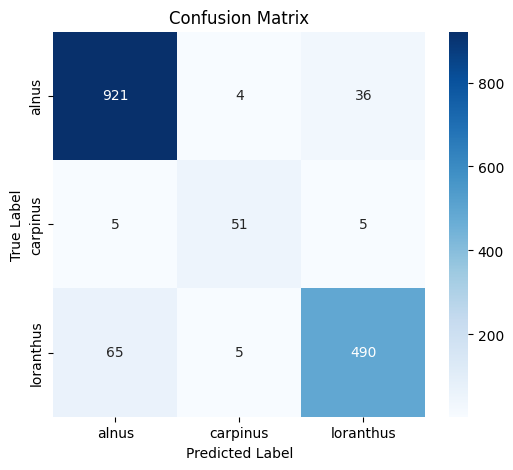

In [10]:
# ─────────── Evaluate on Test Set ───────────
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
# Step 1: Reset test generator to ensure predictions are in correct order
test_gen.reset()

# Step 2: Predict class probabilities
probs = model.predict(test_gen)
pred  = np.argmax(probs, axis=1)   # Convert probabilities to class indices
true  = test_gen.classes           # True class indices

# Step 3: Compute evaluation metrics
acc  = accuracy_score(true, pred)
prec = precision_score(true, pred, average="weighted", zero_division=0)
rec  = recall_score(true, pred, average="weighted")
f1   = f1_score(true, pred, average="weighted")

# Step 4: Print results
print(f"Test Accuracy : {acc:.3f}")
print(f"Test Precision: {prec:.3f}")
print(f"Test Recall   : {rec:.3f}")
print(f"Test F1-score : {f1:.3f}\n")

print("Classification Report:")
print(classification_report(true, pred, target_names=classes, zero_division=0))

# Step 5: Confusion matrix (numeric)
cm = confusion_matrix(true, pred)
print("Confusion Matrix:\n", cm)

# Confusion matrix visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

Bootstrap Accuracy 95% CI: [0.911, 0.937]
Bootstrap F1-score 95% CI: [0.910, 0.937]


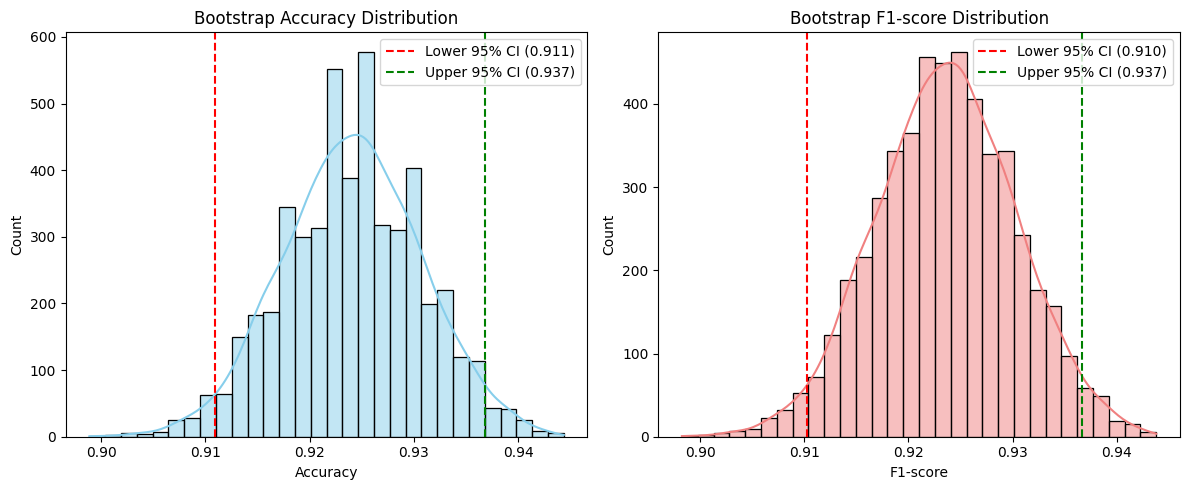

In [11]:
# ─────────── Bootstrap Confidence Interval Calculation ───────────
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_bootstrap = 5000
rng = np.random.default_rng(seed=42)

acc_scores = []
f1_scores = []

for _ in range(n_bootstrap):
    # Sample indices with replacement
    sample_idx = rng.choice(len(true), size=len(true), replace=True)
    y_true_sample = np.array(true)[sample_idx]
    y_pred_sample = np.array(pred)[sample_idx]

    # Compute metrics for this bootstrap sample
    acc_scores.append(accuracy_score(y_true_sample, y_pred_sample))
    f1_scores.append(f1_score(y_true_sample, y_pred_sample, average="weighted"))

# Compute 95% confidence intervals
acc_ci_lower, acc_ci_upper = np.percentile(acc_scores, [2.5, 97.5])
f1_ci_lower, f1_ci_upper = np.percentile(f1_scores, [2.5, 97.5])

print(f"Bootstrap Accuracy 95% CI: [{acc_ci_lower:.3f}, {acc_ci_upper:.3f}]")
print(f"Bootstrap F1-score 95% CI: [{f1_ci_lower:.3f}, {f1_ci_upper:.3f}]")

# ─────────── Plot Bootstrap Distributions ───────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy distribution
sns.histplot(acc_scores, bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].axvline(acc_ci_lower, color="red", linestyle="--", label=f"Lower 95% CI ({acc_ci_lower:.3f})")
axes[0].axvline(acc_ci_upper, color="green", linestyle="--", label=f"Upper 95% CI ({acc_ci_upper:.3f})")
axes[0].set_title("Bootstrap Accuracy Distribution")
axes[0].set_xlabel("Accuracy")
axes[0].legend()

# F1-score distribution
sns.histplot(f1_scores, bins=30, kde=True, ax=axes[1], color="lightcoral")
axes[1].axvline(f1_ci_lower, color="red", linestyle="--", label=f"Lower 95% CI ({f1_ci_lower:.3f})")
axes[1].axvline(f1_ci_upper, color="green", linestyle="--", label=f"Upper 95% CI ({f1_ci_upper:.3f})")
axes[1].set_title("Bootstrap F1-score Distribution")
axes[1].set_xlabel("F1-score")
axes[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# === EXPORT: set up directory and save per-image predictions ===
import os, json, time
import numpy as np
import pandas as pd
from pathlib import Path

STAMP = time.strftime("%Y%m%d_%H%M")
EXPORT_DIR = f"/content/drive/MyDrive/pollen_exports/baseline_{STAMP}"
PLOTS_DIR  = os.path.join(EXPORT_DIR, "plots")
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)
print("Export dir:", EXPORT_DIR)

# Build predictions dataframe (aligned with test_df because shuffle=False)
class_to_idx = train_gen.class_indices
idx_to_class = {v:k for k,v in class_to_idx.items()}
prob_cols = [f"prob_{c}" for c in classes]

preds_df = pd.DataFrame({
    "filepath": test_df["filepath"].values,
    "true":     [idx_to_class[i] for i in true],
    "pred":     [idx_to_class[i] for i in pred],
    **{f"prob_{c}": probs[:, class_to_idx[c]] for c in classes},
})
preds_df["correct"] = (preds_df["true"] == preds_df["pred"]).astype(int)
preds_df.to_csv(os.path.join(EXPORT_DIR, "test_predictions.csv"), index=False)
print("✔ Saved:", os.path.join(EXPORT_DIR, "test_predictions.csv"))

Export dir: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537
✔ Saved: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/test_predictions.csv


In [13]:
# === EXPORT: metrics, classification report, confusion matrix image ===
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

metrics = {
    "accuracy": float(accuracy_score(true, pred)),
    "precision_weighted": float(precision_score(true, pred, average="weighted", zero_division=0)),
    "recall_weighted": float(recall_score(true, pred, average="weighted", zero_division=0)),
    "f1_weighted": float(f1_score(true, pred, average="weighted", zero_division=0)),
    "f1_macro": float(f1_score(true, pred, average="macro", zero_division=0)),
}
with open(os.path.join(EXPORT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print("✔ Saved:", os.path.join(EXPORT_DIR, "metrics.json"))

# classification report (table)
report = classification_report(true, pred, target_names=classes, zero_division=0, output_dict=True)
pd.DataFrame(report).to_csv(os.path.join(EXPORT_DIR, "classification_report.csv"))
print("✔ Saved:", os.path.join(EXPORT_DIR, "classification_report.csv"))

# confusion matrix plot
cm = confusion_matrix(true, pred, labels=list(range(len(classes))))
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel("True Label"); plt.xlabel("Predicted Label"); plt.title("Confusion Matrix")
plt.tight_layout()
cm_path = os.path.join(PLOTS_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=200); plt.close()
print("✔ Saved plot:", cm_path)

✔ Saved: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/metrics.json
✔ Saved: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/classification_report.csv
✔ Saved plot: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/confusion_matrix.png


In [14]:
# === PLOTS: per-class PR & ROC curves ===
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

y_true_onehot = np.zeros((len(true), len(classes)), dtype=int)
for i, t in enumerate(true):
    y_true_onehot[i, t] = 1

# Precision–Recall
plt.figure(figsize=(6,5))
aps = []
for i, c in enumerate(classes):
    prec, rec, _ = precision_recall_curve(y_true_onehot[:, i], probs[:, class_to_idx[c]])
    ap = average_precision_score(y_true_onehot[:, i], probs[:, class_to_idx[c]])
    aps.append(ap)
    plt.plot(rec, prec, label=f"{c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Per-class Precision–Recall")
plt.legend(); plt.tight_layout()
pr_path = os.path.join(PLOTS_DIR, "pr_curves_per_class.png")
plt.savefig(pr_path, dpi=200); plt.close()
print("✔ Saved plot:", pr_path, "| AP:", {c: round(a,3) for c,a in zip(classes, aps)})

# ROC
plt.figure(figsize=(6,5))
aucs = []
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], probs[:, class_to_idx[c]])
    auc = roc_auc_score(y_true_onehot[:, i], probs[:, class_to_idx[c]])
    aucs.append(auc)
    plt.plot(fpr, tpr, label=f"{c} (AUC={auc:.3f})")
plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("Per-class ROC")
plt.legend(); plt.tight_layout()
roc_path = os.path.join(PLOTS_DIR, "roc_curves_per_class.png")
plt.savefig(roc_path, dpi=200); plt.close()
print("✔ Saved plot:", roc_path, "| AUC:", {c: round(a,3) for c,a in zip(classes, aucs)})

✔ Saved plot: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/pr_curves_per_class.png | AP: {'alnus': np.float64(0.988), 'carpinus': np.float64(0.85), 'loranthus': np.float64(0.96)}
✔ Saved plot: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/roc_curves_per_class.png | AUC: {'alnus': np.float64(0.979), 'carpinus': np.float64(0.99), 'loranthus': np.float64(0.979)}


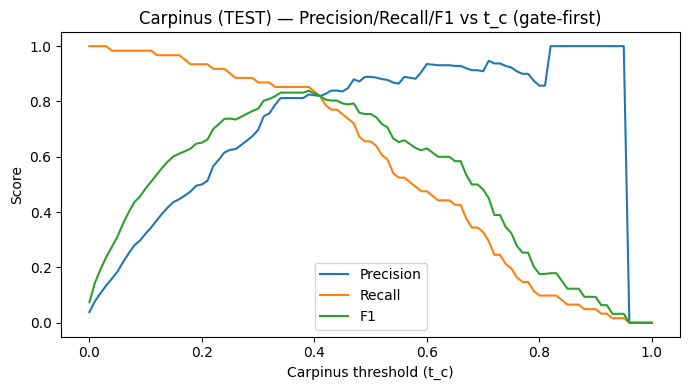

In [16]:
# --- Carpinus threshold sweep (FIXED: force numpy arrays) ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# class index mapping
class_to_idx = train_gen.class_indices
idx_a = class_to_idx['alnus']
idx_c = class_to_idx['carpinus']
idx_l = class_to_idx['loranthus']

# make sure y_true is a numpy array
y_true_np = np.asarray(true).astype(int).ravel()
probs_np  = np.asarray(probs)

def predict_with_carpinus_gate(probs_, t_c, t_a=0.5):
    pa = probs_[:, idx_a]
    pc = probs_[:, idx_c]
    pred = np.full(len(probs_), idx_l, dtype=int)  # default loranthus
    pred[pc >= t_c] = idx_c                        # gate carpinus first
    mask_a = (pred == idx_l) & (pa >= t_a)
    pred[mask_a] = idx_a
    return pred

thr_grid = np.linspace(0.00, 1.00, 101)
p_list, r_list, f_list = [], [], []

for t in thr_grid:
    pred_gate = predict_with_carpinus_gate(probs_np, t_c=t, t_a=0.5)

    # one-vs-rest for Carpinus on TEST
    y_true_c = (y_true_np == idx_c).astype(int)
    y_pred_c = (pred_gate   == idx_c).astype(int)

    p_list.append(precision_score(y_true_c, y_pred_c, zero_division=0))
    r_list.append(recall_score( y_true_c, y_pred_c, zero_division=0))
    f_list.append(f1_score(    y_true_c, y_pred_c, zero_division=0))

plt.figure(figsize=(7,4))
plt.plot(thr_grid, p_list, label="Precision")
plt.plot(thr_grid, r_list, label="Recall")
plt.plot(thr_grid, f_list, label="F1")
plt.xlabel("Carpinus threshold (t_c)")
plt.ylabel("Score")
plt.title("Carpinus (TEST) — Precision/Recall/F1 vs t_c (gate-first)")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# === PLOTS: misclassification galleries ===
import cv2
import matplotlib.pyplot as plt
import os

# helper to draw a grid of images
def show_grid(img_paths, out_path, title, ncols=6, max_imgs=24):
    paths = img_paths[:max_imgs]
    n = len(paths)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(ncols*2, nrows*2))
    for i, p in enumerate(paths):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img); ax.axis("off")
    plt.suptitle(title); plt.tight_layout(rect=[0,0,1,0.97])
    plt.savefig(out_path, dpi=200); plt.close()

# collect misclassified groups
mis = preds_df[preds_df["correct"] == 0].copy()

pairs = [
    ("loranthus", "alnus"),
    ("alnus", "loranthus"),
    ("alnus", "carpinus"),
    ("loranthus", "carpinus"),
    ("carpinus", "alnus"),
    ("carpinus", "loranthus"),
]

for t, p_ in pairs:
    sub = mis[(mis["true"] == t) & (mis["pred"] == p_)].copy()
    # sort by predicted prob for the wrong class (가장 '확신 있게' 틀린 사례)
    if len(sub):
        sub = sub.sort_values(f"prob_{p_}", ascending=False)
        out_path = os.path.join(PLOTS_DIR, f"mis_{t}_to_{p_}.png")
        show_grid(sub["filepath"].tolist(), out_path, f"Misclassified: {t} → {p_}")
        print(f"✔ Saved gallery: {out_path}  (n={len(sub)})")

✔ Saved gallery: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/mis_loranthus_to_alnus.png  (n=65)
✔ Saved gallery: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/mis_alnus_to_loranthus.png  (n=36)
✔ Saved gallery: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/mis_alnus_to_carpinus.png  (n=4)
✔ Saved gallery: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/mis_loranthus_to_carpinus.png  (n=5)
✔ Saved gallery: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/mis_carpinus_to_alnus.png  (n=5)
✔ Saved gallery: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537/plots/mis_carpinus_to_loranthus.png  (n=5)


In [18]:
# === EXPORT: save bootstrap plots you just generated ===
plt.figure(figsize=(6,4))
sns.histplot(acc_scores, bins=30, kde=True)
plt.axvline(acc_ci_lower, color="red", linestyle="--", label=f"Lower 95% CI ({acc_ci_lower:.3f})")
plt.axvline(acc_ci_upper, color="green", linestyle="--", label=f"Upper 95% CI ({acc_ci_upper:.3f})")
plt.title("Bootstrap Accuracy Distribution"); plt.xlabel("Accuracy"); plt.legend()
acc_boot_path = os.path.join(PLOTS_DIR, "bootstrap_accuracy.png")
plt.tight_layout(); plt.savefig(acc_boot_path, dpi=200); plt.close()

plt.figure(figsize=(6,4))
sns.histplot(f1_scores, bins=30, kde=True)
plt.axvline(f1_ci_lower, color="red", linestyle="--", label=f"Lower 95% CI ({f1_ci_lower:.3f})")
plt.axvline(f1_ci_upper, color="green", linestyle="--", label=f"Upper 95% CI ({f1_ci_upper:.3f})")
plt.title("Bootstrap F1 (weighted) Distribution"); plt.xlabel("F1-score"); plt.legend()
f1_boot_path = os.path.join(PLOTS_DIR, "bootstrap_f1_weighted.png")
plt.tight_layout(); plt.savefig(f1_boot_path, dpi=200); plt.close()

# also save raw arrays
np.savez_compressed(os.path.join(EXPORT_DIR, "bootstrap_raw.npz"),
                    acc_scores=np.array(acc_scores),
                    f1_scores=np.array(f1_scores),
                    acc_ci=np.array([acc_ci_lower, acc_ci_upper]),
                    f1_ci=np.array([f1_ci_lower, f1_ci_upper]))
print("✔ Saved bootstrap plots and raw arrays")

✔ Saved bootstrap plots and raw arrays


In [20]:
# === Save model (Keras 3 friendly) ===
import os, json

# 1) Native Keras format (권장, 단일 파일)
model.save(os.path.join(EXPORT_DIR, "model.keras"))

# 2) H5 포맷(호환 필요시)
model.save(os.path.join(EXPORT_DIR, "model.h5"))

# 3) TensorFlow SavedModel 디렉터리(서빙/TFLite 등)
model.export(os.path.join(EXPORT_DIR, "saved_model"))  # ← 예전 model.save(.../saved_model) 대신 export 사용
print("✔ Saved: model.keras, model.h5, and saved_model/")

# (그 외 config/label mapping 저장은 기존 코드 그대로 두면 됩니다)

Saved artifact at '/content/drive/MyDrive/pollen_exports/baseline_20250811_1537/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  138079457863312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138079457861968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138079457863504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138079457864656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138079457864464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138079457865040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138077435767184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138077435769488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138077435771408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138077435771600: TensorS

In [21]:
# === ZIP & (optionally) download ===
import shutil
zip_base = EXPORT_DIR.rstrip("/")

shutil.make_archive(zip_base, 'zip', EXPORT_DIR)
print("ZIP created:", zip_base + ".zip")

from google.colab import files
files.download(zip_base + ".zip")  # 주석 해제하면 브라우저로 다운로드

ZIP created: /content/drive/MyDrive/pollen_exports/baseline_20250811_1537.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

A — 클래스별 요약 테이블
	•	무엇: 각 클래스의 Precision/Recall/F1/Support와 macro·weighted 평균.
	•	어떻게: precision_recall_fscore_support로 per-class 지표 계산 → 표로 출력.
	•	의미: 클래스별 강약점 파악(예: 소수 클래스의 R/P 불균형), macro vs weighted 비교.

In [22]:
import numpy as np, pandas as pd
from sklearn.metrics import precision_recall_fscore_support

idx2class = {v:k for k,v in train_gen.class_indices.items()}
y_true = np.asarray(true).astype(int)
y_pred = np.asarray(pred).astype(int)

prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=range(len(classes)), zero_division=0)
df_summary = pd.DataFrame({
    "class": classes,
    "precision": np.round(prec, 3),
    "recall":    np.round(rec, 3),
    "f1":        np.round(f1, 3),
    "support":   sup
})
df_summary.loc["macro_avg"] = ["macro_avg",
                               np.round(df_summary["precision"].mean(),3),
                               np.round(df_summary["recall"].mean(),3),
                               np.round(df_summary["f1"].mean(),3),
                               df_summary["support"].sum()]
df_summary.loc["weighted_avg"] = ["weighted_avg",
                                  np.round(np.average(df_summary["precision"], weights=df_summary["support"]),3),
                                  np.round(np.average(df_summary["recall"],    weights=df_summary["support"]),3),
                                  np.round(np.average(df_summary["f1"],        weights=df_summary["support"]),3),
                                  df_summary["support"].sum()]
display(df_summary)

,class,precision,recall,f1,support
0,alnus,0.929,0.958,0.944,961
1,carpinus,0.850,0.836,0.843,61
2,loranthus,0.923,0.875,0.898,560
macro_avg,macro_avg,0.901,0.890,0.895,1582
weighted_avg,weighted_avg,0.912,0.907,0.909,3164


B — 정규화 혼동행렬 (행 합=1)
	•	무엇: True 라벨 기준으로 예측 분포를 확률처럼 보여주는 CM.
	•	어떻게: confusion_matrix → 행별 합으로 나눠 Heatmap.
	•	의미: “무엇을 무엇으로” 착각하는지 상대비율로 확인(Loranthus↔Alnus 교차 등).

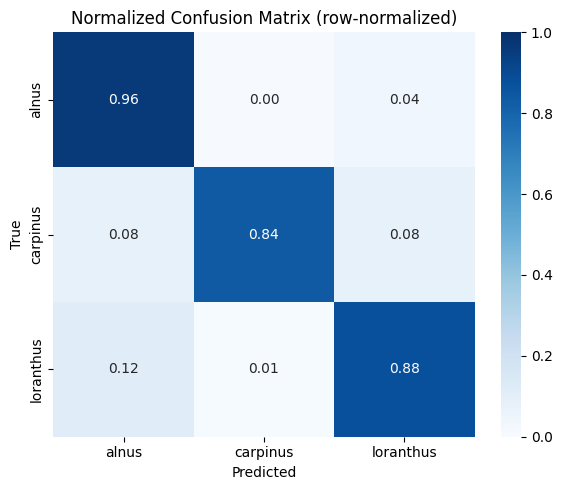

In [23]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes, vmin=0, vmax=1)
plt.title("Normalized Confusion Matrix (row-normalized)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

C — 클래스별 PR 곡선 (+ AP)
	•	무엇: One-vs-Rest PR 커브와 Average Precision(AP).
	•	어떻게: 각 클래스에 대해 precision_recall_curve & average_precision_score.
	•	의미: 임계값 조절 시 P/R 트레이드오프와 면적(AP)로 난이도/분리도 평가.

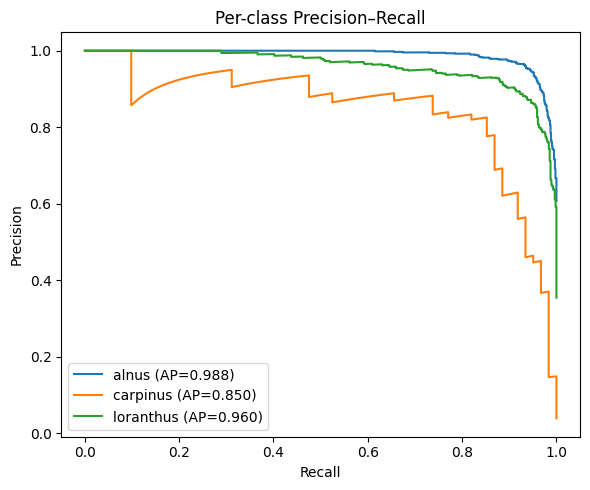

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

y_true_oh = np.zeros((len(y_true), len(classes)), dtype=int)
for i, t in enumerate(y_true):
    y_true_oh[i, t] = 1

plt.figure(figsize=(6,5))
for i, c in enumerate(classes):
    p, r, _ = precision_recall_curve(y_true_oh[:, i], probs[:, train_gen.class_indices[c]])
    ap = average_precision_score(y_true_oh[:, i], probs[:, train_gen.class_indices[c]])
    plt.plot(r, p, label=f"{c} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Per-class Precision–Recall")
plt.legend(); plt.tight_layout(); plt.show()

D — 클래스별 ROC 곡선 (+ AUC)
	•	무엇: One-vs-Rest ROC와 AUC.
	•	어떻게: roc_curve, roc_auc_score.
	•	의미: 클래스별 판별능력(거짓양성률 vs 진양성률) 확인. AUC로 전체 성능 요약.

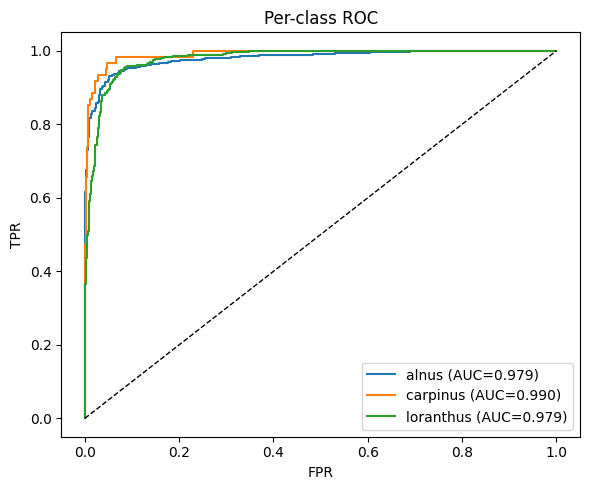

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(6,5))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], probs[:, train_gen.class_indices[c]])
    auc = roc_auc_score(y_true_oh[:, i], probs[:, train_gen.class_indices[c]])
    plt.plot(fpr, tpr, label=f"{c} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Per-class ROC")
plt.legend(); plt.tight_layout(); plt.show()

E — 칼리브레이션(리라이어빌리티) 곡선
	•	무엇: 예측확률의 보정 정도(예: 0.8로 예측한 샘플이 실제로 80% 맞는가?).
	•	어떻게: calibration_curve로 10-bin 균등 분할 후 예측 vs 실측 확률 플롯.
	•	의미: 확률이 과신/과소인지 확인 → 임계값 선택·언서턴티 기반 후처리에 유용.

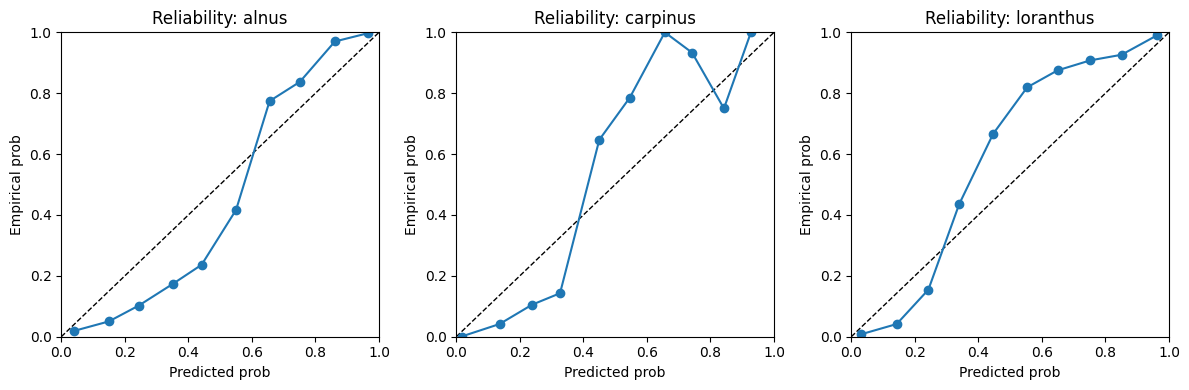

In [26]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i, c in enumerate(classes):
    prob_true, prob_pred = calibration_curve(y_true_oh[:, i], probs[:, train_gen.class_indices[c]], n_bins=10, strategy="uniform")
    ax = plt.subplot(1, len(classes), i+1)
    ax.plot([0,1],[0,1],'k--',lw=1)
    ax.plot(prob_pred, prob_true, marker='o')
    ax.set_title(f"Reliability: {c}")
    ax.set_xlabel("Predicted prob"); ax.set_ylabel("Empirical prob")
    ax.set_xlim(0,1); ax.set_ylim(0,1)
plt.tight_layout(); plt.show()

F — 확신도 히스토그램(정답 vs 오답)
	•	무엇: argmax(prob)의 최대확률 분포를 정답/오답으로 분리한 히스토그램.
	•	어떻게: probs.max(axis=1) 계산 → 두 분포를 겹쳐 그림.
	•	의미: 오답이 낮은 확신도에 몰려 있으면 임계값 상향/거부 클래스 도입 근거.

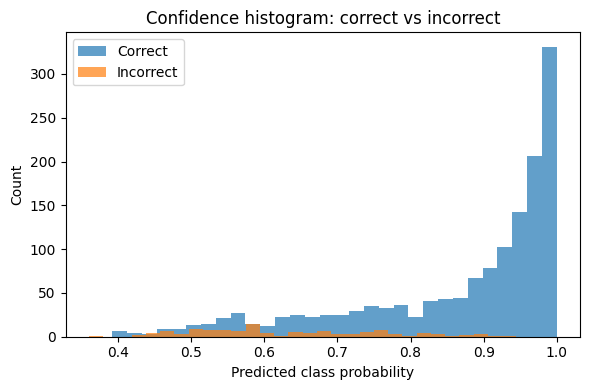

In [27]:
import numpy as np, matplotlib.pyplot as plt

# 예측한 클래스의 확률(최대 확률)
max_prob = probs.max(axis=1)
is_correct = (y_true == y_pred)

plt.figure(figsize=(6,4))
plt.hist(max_prob[is_correct], bins=30, alpha=0.7, label="Correct")
plt.hist(max_prob[~is_correct], bins=30, alpha=0.7, label="Incorrect")
plt.xlabel("Predicted class probability"); plt.ylabel("Count")
plt.title("Confidence histogram: correct vs incorrect")
plt.legend(); plt.tight_layout(); plt.show()

G — 오분류 갤러리(페어별 이미지)
	•	무엇: 대표적인 오분류 페어(예: Loranthus→Alnus)를 확신도 높은 순으로 타일 미리보기.
	•	어떻게: preds_df에서 true≠pred만 필터 → prob_{pred} 내림차순 정렬 → 그리드 표시.
	•	의미: 시각적 에러 패턴(형태 유사성, 대비/초점 문제, 아티팩트) 질적 분석용. 논문 Figure로 매우 유용.

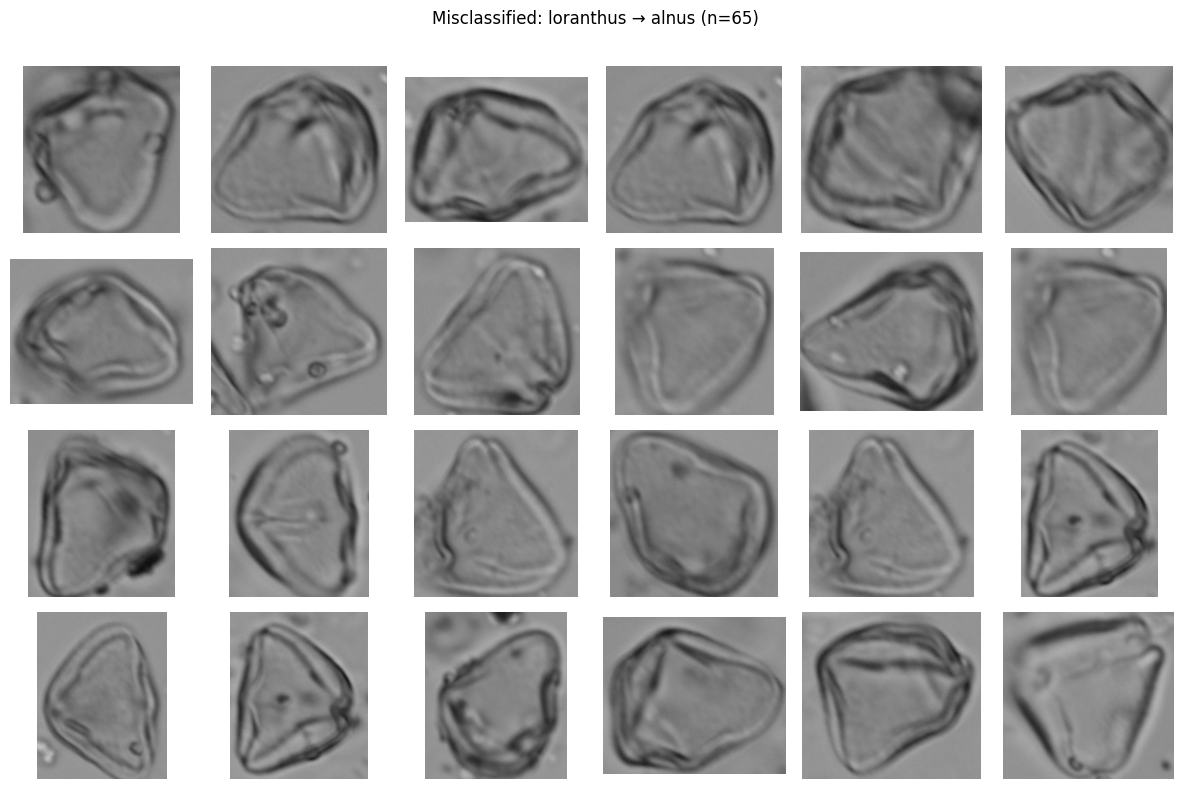

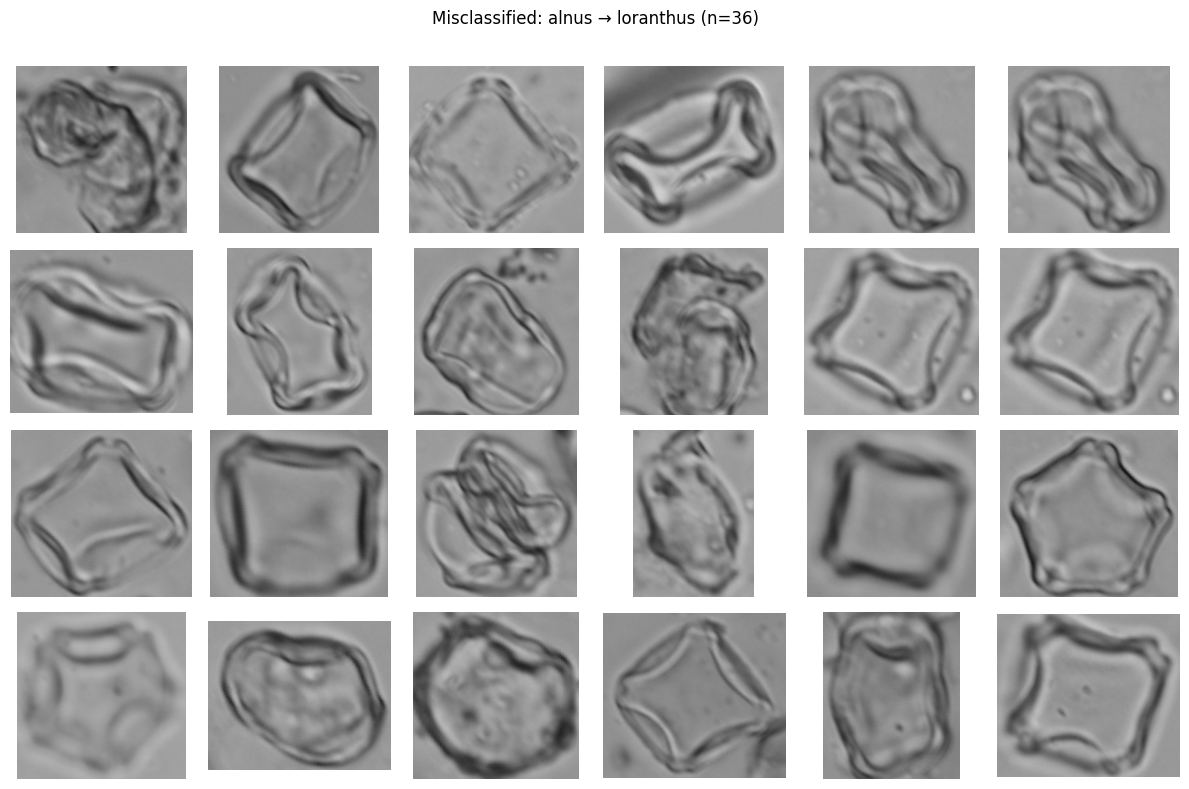

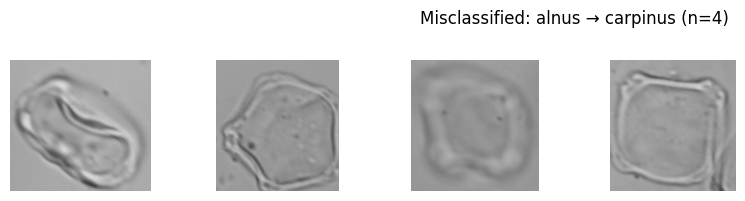

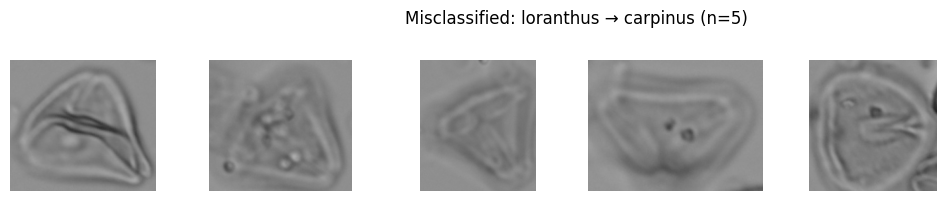

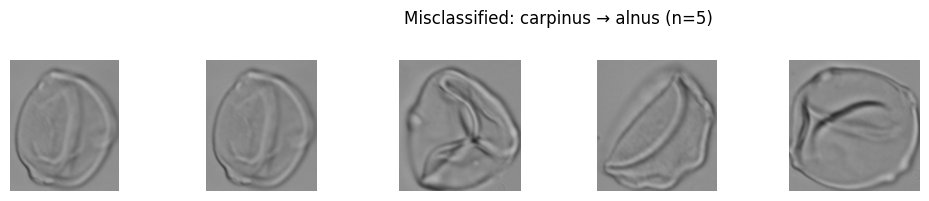

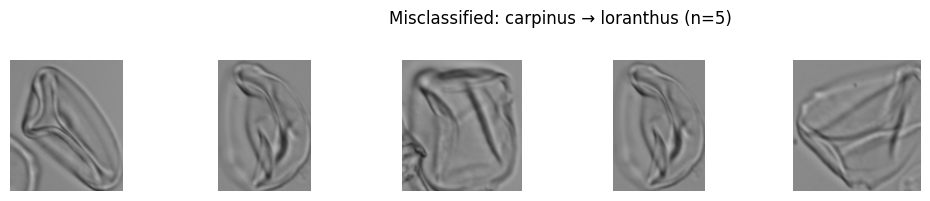

In [28]:
import pandas as pd, cv2, matplotlib.pyplot as plt, numpy as np

# 1) 예측 테이블 구성
prob_cols = {c: probs[:, train_gen.class_indices[c]] for c in classes}
preds_df = pd.DataFrame({
    "filepath": test_df["filepath"].values,
    "true": [classes[i] for i in y_true],
    "pred": [classes[i] for i in y_pred],
    **{f"prob_{c}": prob_cols[c] for c in classes},
})
preds_df["correct"] = (preds_df["true"] == preds_df["pred"]).astype(int)

# 2) 미스 페어별 상위 예시
pairs = [("loranthus", "alnus"),
         ("alnus", "loranthus"),
         ("alnus", "carpinus"),
         ("loranthus", "carpinus"),
         ("carpinus", "alnus"),
         ("carpinus", "loranthus")]

def show_grid(paths, title, ncols=6, max_imgs=24):
    paths = paths[:max_imgs]; n = len(paths)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(ncols*2, nrows*2))
    for i, p in enumerate(paths):
        img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
        ax = plt.subplot(nrows, ncols, i+1)
        ax.imshow(img); ax.axis("off")
    plt.suptitle(title); plt.tight_layout(rect=[0,0,1,0.97]); plt.show()

for t, p_ in pairs:
    sub = preds_df[(preds_df["true"]==t) & (preds_df["pred"]==p_)].copy()
    if len(sub)==0:
        continue
    # 가장 '확신 있게' 틀린 케이스부터
    sub = sub.sort_values(f"prob_{p_}", ascending=False)
    show_grid(sub["filepath"].tolist(), f"Misclassified: {t} → {p_} (n={len(sub)})")

H — Carpinus 임계값 스윕 곡선
	•	무엇: 게이팅 규칙(Carpinus 먼저 판단)에서 t_c를 바꿀 때 P/R/F1 변화(테스트 기준).
	•	어떻게: t_c 0~1 스윕 → one-vs-rest로 Carpinus만 점수 계산해 곡선 3개(Precision, Recall, F1).
	•	의미: 운영 목표(예: P≥0.8) 충족하는 임계값 선택 근거 제공. 보고서에 “운영점 선택” 정당화.

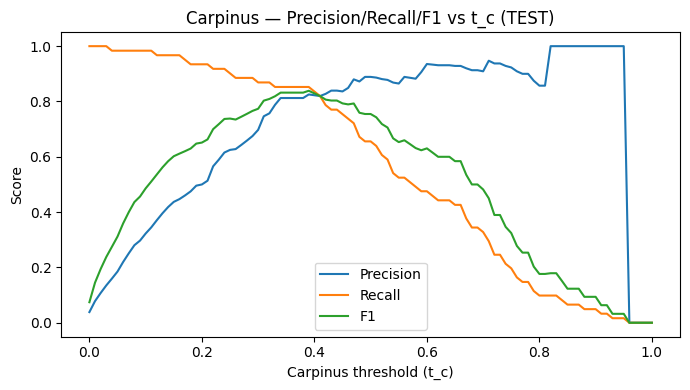

In [29]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

idx = {c:i for c,i in train_gen.class_indices.items()}
idx_a, idx_c, idx_l = idx["alnus"], idx["carpinus"], idx["loranthus"]
y_true_np = np.asarray(y_true).astype(int)
probs_np  = np.asarray(probs)

def predict_with_carpinus_gate(probs_, t_c, t_a=0.5):
    pa = probs_[:, idx_a]; pc = probs_[:, idx_c]
    pred_gate = np.full(len(probs_), idx_l, dtype=int)
    pred_gate[pc >= t_c] = idx_c
    mask_a = (pred_gate == idx_l) & (pa >= t_a)
    pred_gate[mask_a] = idx_a
    return pred_gate

thr_grid = np.linspace(0.00, 1.00, 101)
p_list, r_list, f_list = [], [], []
for t in thr_grid:
    pred_gate = predict_with_carpinus_gate(probs_np, t_c=t, t_a=0.5)
    y_true_c = (y_true_np == idx_c).astype(int)
    y_pred_c = (pred_gate   == idx_c).astype(int)
    p_list.append(precision_score(y_true_c, y_pred_c, zero_division=0))
    r_list.append(recall_score( y_true_c, y_pred_c, zero_division=0))
    f_list.append(f1_score(    y_true_c, y_pred_c, zero_division=0))

plt.figure(figsize=(7,4))
plt.plot(thr_grid, p_list, label="Precision")
plt.plot(thr_grid, r_list, label="Recall")
plt.plot(thr_grid, f_list, label="F1")
plt.xlabel("Carpinus threshold (t_c)")
plt.ylabel("Score")
plt.title("Carpinus — Precision/Recall/F1 vs t_c (TEST)")
plt.legend(); plt.tight_layout(); plt.show()

I — 고불확실성(엔트로피 Top-N) 갤러리
	•	무엇: 예측 확률의 엔트로피가 높은 샘플 Top-N 이미지.
	•	어떻게: entropy = -(p*log p) 합(클래스수로 정규화) → 상위 N개 그리드 표시.
	•	의미: 모델이 가장 애매해하는 케이스 확인(추가 주석/데이터 클리닝/하드 예시 증강 후보).


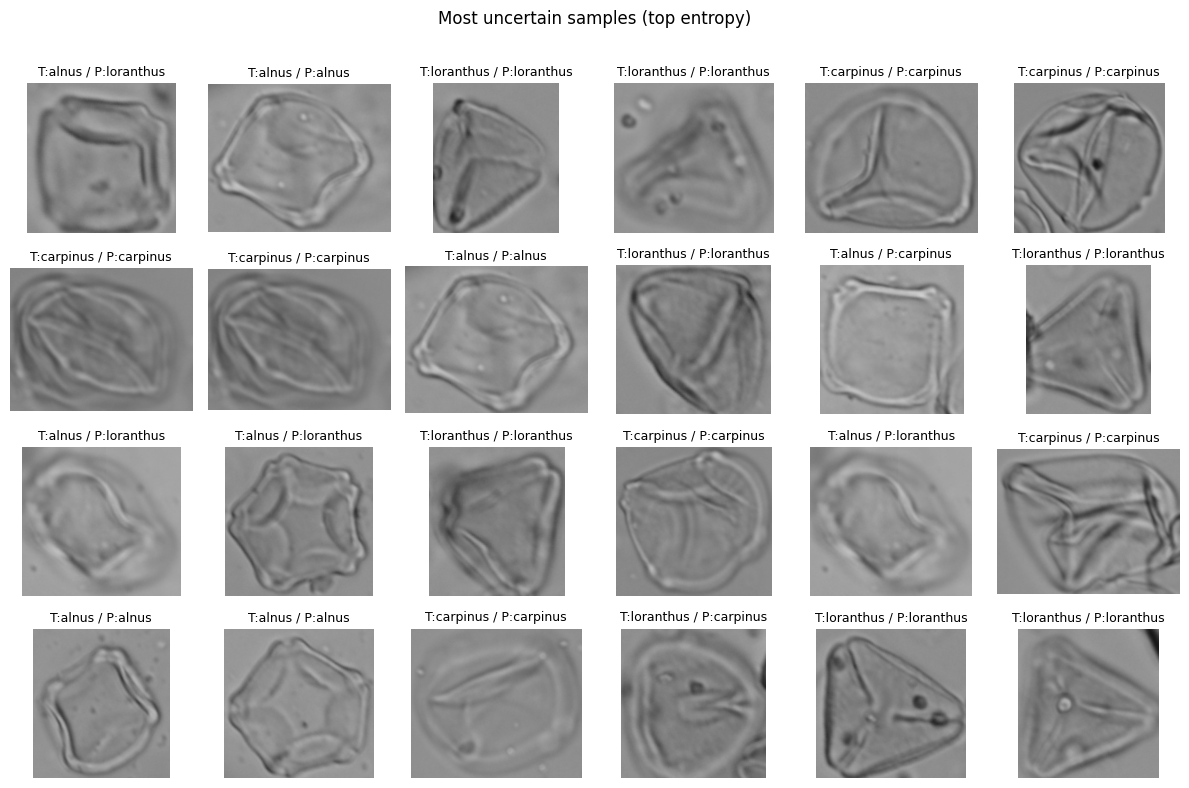

In [30]:
import numpy as np, matplotlib.pyplot as plt, cv2

eps = 1e-12
entropy = -(probs * np.log(probs + eps)).sum(axis=1) / np.log(probs.shape[1])
idx_sorted = np.argsort(-entropy)  # 높은 엔트로피부터

N = 24
sel = idx_sorted[:N]
paths = test_df.iloc[sel]["filepath"].tolist()
labels_true = [classes[i] for i in y_true[sel]]
labels_pred = [classes[i] for i in y_pred[sel]]

ncols=6; nrows=int(np.ceil(N/ncols))
plt.figure(figsize=(ncols*2, nrows*2))
for i,(p,tv,pv) in enumerate(zip(paths, labels_true, labels_pred)):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(nrows, ncols, i+1)
    ax.imshow(img); ax.axis("off")
    ax.set_title(f"T:{tv} / P:{pv}", fontsize=9)
plt.suptitle("Most uncertain samples (top entropy)"); plt.tight_layout(rect=[0,0,1,0.97]); plt.show()

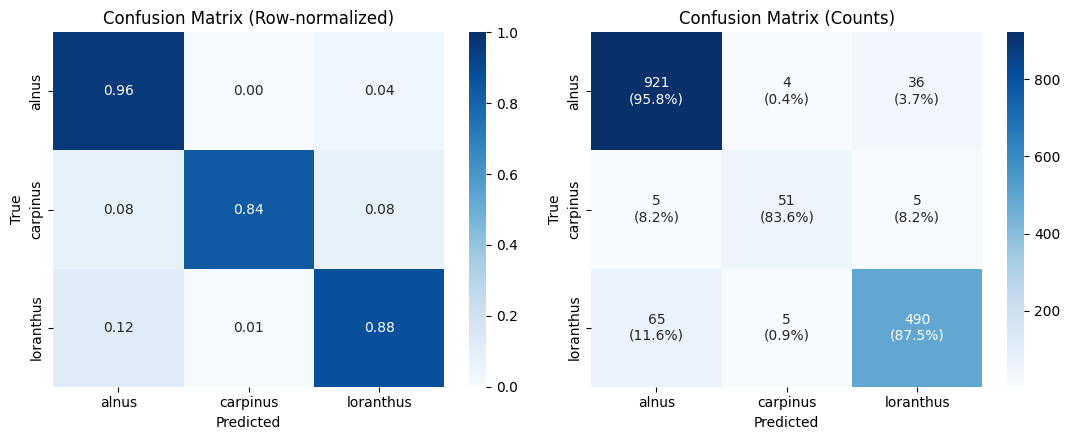

In [31]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = np.asarray(true).astype(int)
y_pred = np.asarray(pred).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))
# 1) 정규화
sns.heatmap(cm_norm, ax=axes[0], annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes, vmin=0, vmax=1)
axes[0].set_title("Confusion Matrix (Row-normalized)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("True")

# 2) 원시 카운트 (주석에 비율도 같이 표기)
annot = np.empty_like(cm).astype(object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)"
sns.heatmap(cm, ax=axes[1], annot=annot, fmt="", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
axes[1].set_title("Confusion Matrix (Counts)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("True")

plt.tight_layout(); plt.show()